In [1]:
from ibmm import EyeClassifier
# from ibmm_online import EyeClassifierOnline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import cm

from parser_utils import read_periph_recording, parse_new_dreyevr_rec, GetGazeDeviationFromHead
from pathlib import Path
from tqdm import tqdm
import pickle as pkl

In [2]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append(".\\dreyevr_parser")

In [4]:
import sys
sys.path.append(".\\dreyevr_parser")
from dreyevr_parser.parser import parse_file
from typing import Dict, List, Any
from utils import (
    check_for_periph_data,
    convert_to_df,
    split_along_subgroup,
    get_good_idxs,
)
from visualizer import plot_versus

In [12]:
!dir "C:/carla/carla.periph/RecordingTxts/pre-newCA/brady"

 Volume in drive C has no label.
 Volume Serial Number is 3C35-7F58

 Directory of C:\carla\carla.periph\RecordingTxts\pre-newCA\brady

03/23/2022  04:27 PM    <DIR>          .
03/23/2022  04:27 PM    <DIR>          ..
03/23/2022  03:47 PM       185,256,485 brady11.txt
03/23/2022  03:47 PM       142,664,266 brady21.txt
03/23/2022  03:47 PM        80,410,377 brady32.txt
03/23/2022  03:47 PM        93,739,172 brady54.txt
03/23/2022  03:47 PM        64,852,110 brady55.txt
               5 File(s)    566,922,410 bytes
               2 Dir(s)  181,757,624,320 bytes free


In [15]:

path_to_recording = "C://carla//carla.periph//RecordingTxts//tab/tab55.txt"
path_to_recording = "C://carla//carla.periph//RecordingTxts//esther//esther55.txt"
path_to_recording = "C://carla//carla.periph//RecordingTxts//pre-newCA//brady//brady32.txt"
# path_to_recording = "C://carla//carla.periph//RecordingTxts//jacob/jacob55.txt"
# path_to_recording = "C://carla//carla.periph//RecordingTxts//george//george-55.txt"

recording_name = Path(path_to_recording).stem
recdf_pklname = Path("temp_data").joinpath(recording_name+".pkl")

# try:
#     df1 = pd.read_pickle(recdf_pklname)
# except FileNotFoundError:
#     df1 = read_periph_recording(path_to_recording)
#     df1.to_pickle(recdf_pklname)
# df1 = df1.convert_dtypes()

In [16]:
data: Dict[str, np.ndarray or dict] = parse_file(path_to_recording)

"""append/generate periph data if available"""
# check for periph data
PeriphData = check_for_periph_data(data)
if PeriphData is not None:
    data["PeriphData"] = PeriphData

"""convert to pandas df"""
# need to split along groups so all data lengths are the same
data_groups = split_along_subgroup(data, ["CustomActor"])
data_groups_df: List[pd.DataFrame] = [convert_to_df(x) for x in data_groups]
df_new = data_groups_df[0]

Did not find data at cache\brady32.pkl
Reading DReyeVR recording file: C://carla//carla.periph//RecordingTxts//pre-newCA//brady//brady32.txt
successfully read 9157 frames in 5.608s
cached data to cache\brady32.pkl
gathered periph data in 0.000s
created DReyeVR df in 0.200s


In [17]:
df = parse_new_dreyevr_rec(path_to_recording, False)
df1 = df.copy()

100%|█████████████████████████████████████████████████████████████████████████████| 9156/9156 [00:40<00:00, 226.68it/s]


In [26]:
df_new.iloc[38,:]

TimeElapsed                                          1.99257
TimestampCarla                                          9337
TimestampDevice                                      1973661
FrameSequence                                       22298523
GazeDir_COMBINED                       [0.991, 0.135, 0.012]
GazeOrigin_COMBINED                    [-2.77, -0.186, 0.12]
GazeValid_COMBINED                                         1
GazeVergence_COMBINED                               278.0133
GazeDir_LEFT                           [0.992, 0.124, 0.011]
GazeOrigin_LEFT                       [-2.517, 2.946, 0.131]
GazeValid_LEFT                                             1
EyeOpenness_LEFT                                      0.7866
EyeOpennessValid_LEFT                                      1
PupilDiameter_LEFT                                     4.186
PupilPosition_LEFT                             [0.22, 0.005]
PupilPositionValid_LEFT                                    1
GazeDir_RIGHT           

In [19]:
from pandas.testing import assert_frame_equal, assert_series_equal
assert_series_equal(df1.reset_index().PupilPosition_RIGHT, df_new.reset_index().PupilPosition_RIGHT[:-1], check_index_type=False)
assert_series_equal(df1.reset_index().ButtonPressed, df_new.reset_index().ButtonPressed[:-1].convert_dtypes(), check_index_type=False)
# df1 = df_new

In [ ]:
df_legacy, df1 = df1, df_new

## Data Playground and Sanity checks

In [ ]:
df1.columns

In [27]:
# find the indices where lights came on and went off
lighton_rows = df1["LightOn"].diff().fillna(0)==1
lightoff_rows = df1["LightOn"].diff().fillna(0)==-1
df1[lighton_rows].head()
lighton_idcs = df1[lighton_rows].index
num_targets_spawned = sum(lighton_rows)
# find the indices where the button was pressed
buttonPress_rows = df1["ButtonPressed"].diff().fillna(0)==1
buttonRelease_rows = df1["ButtonPressed"].diff().fillna(0)==-1
num_button_presses = sum(buttonPress_rows)
print("{} targets spawned".format(num_targets_spawned))
print("{} responses recorded".format(num_button_presses)) # may or may not be all accurate responses that correspond to targets?

19 targets spawned
10 responses recorded


In [28]:
df2 = df1.copy()
df2['gaze_x'] = df1.GazeDir_COMBINED.apply(lambda x: x[0])
df2['gaze_y'] = df1.GazeDir_COMBINED.apply(lambda x: x[1])
df2['gaze_z'] = df1.GazeDir_COMBINED.apply(lambda x: x[2])

gaze_pitches = np.arctan2(df2.gaze_z, df2.gaze_x)*180/np.pi
gaze_yaws = np.arctan2(df2.gaze_y, df2.gaze_x)*180/np.pi

low_conf_gazeidcs = (gaze_pitches*gaze_yaws == 0)
gaze_pitches = gaze_pitches[~low_conf_gazeidcs]
gaze_yaws = gaze_yaws[~low_conf_gazeidcs]


print(np.min(gaze_pitches),np.max(gaze_pitches))
print(np.min(gaze_yaws),np.max(gaze_yaws))

-29.759162398220024 15.78075330951539
-33.46537934635529 38.929264393473936


In [29]:
#gaze_pitches = gaze_pitches[1000:7000]
#gaze_yaws = gaze_yaws[6000:7000]

# Generate heat map of eye gaze wrt head pos
plt.figure()
plt.hist2d(gaze_yaws, gaze_pitches,
           bins=50, cmap='hot')
cb = plt.colorbar()
cb.set_label('Number of points')
plt.title('Heatmap of eye gaze wrt head direction')
# plt.xlim(-20,20)
# plt.ylim(-20,20)
plt.xlabel('yaw')
plt.ylabel('pitch')
plt.show()

C:\Users\Abhijat\AppData\Local\Temp/ipykernel_43532/3059153711.py:15: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


## Hits and Misses calculation

In [30]:
# for every light appearance
# find the nearest button press, before the next target appearance
max_reaction_time_allowed = 5 #seconds
time_offsets = []
hits_and_misses = []
for idx_num, lighton_idx in tqdm(enumerate(lighton_idcs)):
    # while not found_buttonpress or lighton_idcs[idx_num+1]:
    offset = 0
    target_tuple = (df1.loc[lighton_idx], False)
    while lighton_idx+offset < max(df1.index):
        time_offset = df1.loc[lighton_idx+offset, "TimeElapsed"] - df1.loc[lighton_idx, "TimeElapsed"]   
        if (df1.loc[lighton_idx+offset, "ButtonPressed"] == 1):
            # print( "{0:1.2f}s".format(time_offset))
            time_offsets += [time_offset]
            target_tuple = (df1.loc[lighton_idx], df1.loc[lighton_idx+offset])
            break
        else:
            if time_offset > max_reaction_time_allowed:
                break
            offset += 1
    hits_and_misses += [target_tuple]
    
print("{}/{} hits with a {}s average reaction time".format(len(time_offsets), len(lighton_idcs), sum(time_offsets)/len(time_offsets)))

19it [00:00, 34.51it/s]

10/19 hits with a 0.789119999999994s average reaction time


## Prelim analysis

In [34]:
for target_tuple in hits_and_misses:
    if target_tuple[1] is False:
        # miss
        print(target_tuple[0]) 

TimeElapsed                                           3.02039
TimestampCarla                                          10432
TimestampDevice                                       4195767
FrameSequence                                       175670705
GazeDir_COMBINED                         [0.913, 0.061, -0.4]
GazeOrigin_COMBINED                      [-2.3, 0.165, 0.045]
GazeValid_COMBINED                                          1
GazeVergence_COMBINED                                 74.3605
GazeDir_LEFT                           [0.915, 0.021, -0.404]
GazeOrigin_LEFT                        [-2.295, 3.179, 0.065]
GazeValid_LEFT                                              1
EyeOpenness_LEFT                                       0.9579
EyeOpennessValid_LEFT                                       1
PupilDiameter_LEFT                                     2.9534
PupilPosition_LEFT                            [0.063, -0.153]
PupilPositionValid_LEFT                                     1
GazeDir_

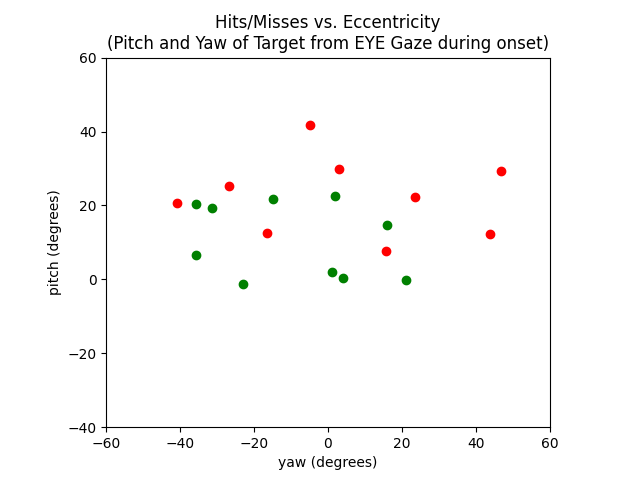

In [37]:
# Preliminary analysis
fig, ax = plt.subplots()

# plots of hits misses vs ecc
for target_tuple in hits_and_misses:
    target_response = True
    if target_tuple[1] is False:
        # miss
        target_response = False
        pass
    else:
        # hits
        pass
        # print(target_tuple[1].ButtonPressed)
    ax.scatter(target_tuple[0].gaze2target_yaw*180/np.pi,
               target_tuple[0].gaze2target_pitch*180/np.pi,
               c='g' if target_response else 'r')
    ax.set_title("Hits/Misses vs. Eccentricity\n(Pitch and Yaw of Target from EYE Gaze during onset)")
    
    # ax.scatter(target_tuple[0].head2target_yaw*180/np.pi, target_tuple[0].head2target_pitch*180/np.pi, c='g' if target_response else 'r')
    # ax.set_title("Hits/Misses vs. Eccentricity\n(Pitch and Yaw of Target from HEAD Gaze during onset)")
    
    ax.set_xlabel("yaw (degrees)")
    ax.set_ylabel("pitch (degrees)")
    ax.set_xlim(-60, 60)
    ax.set_ylim(-40, 60)
    ax.set_aspect('equal')
    # ax.show()

## Gaze event detection (gaze vector/gaze+head only)


In [38]:
from ibmm import EyeClassifier
from ibmm_online import EyeClassifierOnline

In [39]:
gazeORgazeHead = "gazeHead"

In [40]:
df2 = df1.copy()
if gazeORgazeHead == "gaze":
    df2['Lgaze_x'] = df1.GazeDir_LEFT.apply(lambda x: x[0])
    df2['Lgaze_y'] = df1.GazeDir_LEFT.apply(lambda x: x[1])
    df2['Lgaze_z'] = df1.GazeDir_LEFT.apply(lambda x: x[2])

    df2['Rgaze_x'] = df1.GazeDir_RIGHT.apply(lambda x: x[0])
    df2['Rgaze_y'] = df1.GazeDir_RIGHT.apply(lambda x: x[1])
    df2['Rgaze_z'] = df1.GazeDir_RIGHT.apply(lambda x: x[2])


    LgazeRaySplitDF = pd.DataFrame(df2[['Lgaze_x', 'Lgaze_y', 'Lgaze_z']])
    LgazeRaySplitDF.rename(columns={'Lgaze_x': 'x', 'Lgaze_y': 'y', 'Lgaze_z': 'z'}, inplace=True)
    LgazeRaySplitDF['timestamp'] = df2["TimeElapsed"]
    LgazeRaySplitDF['confidence'] = df2["EyeOpennessValid_LEFT"].astype(bool) # remove all gazes where an eye was closed

    RgazeRaySplitDF = pd.DataFrame(df2[['Rgaze_x', 'Rgaze_y', 'Rgaze_z']])
    RgazeRaySplitDF.rename(columns={'Rgaze_x': 'x', 'Rgaze_y': 'y', 'Rgaze_z': 'z'}, inplace=True)
    RgazeRaySplitDF['timestamp'] = df2["TimeElapsed"]
    RgazeRaySplitDF['confidence'] = df2["EyeOpennessValid_RIGHT"].astype(bool) # remove all gazes where an eye was closed
    
    velL = EyeClassifier.preprocess(LgazeRaySplitDF, dist_method='vector')
    velL.velocity = velL.velocity.astype(float)
    velR = EyeClassifier.preprocess(RgazeRaySplitDF, dist_method='vector')
    velR.velocity = velR.velocity.astype(float)
    model = EyeClassifier()
    model.fit(eyes=(velL, velR))
    labels, indiv_labels = model.predict(eyes=(velL, velR))
    labels_unique = labels[1::2]
    
elif gazeORgazeHead == "gazeHead":
    # add approx head compensation
    df2['Cgaze_x'] = df1.GazeDir_COMBINED.apply(lambda x: x[0])
    df2['Cgaze_y'] = df1.GazeDir_COMBINED.apply(lambda x: x[1])
    df2['Cgaze_z'] = df1.GazeDir_COMBINED.apply(lambda x: x[2])

    # gaze+head values
    gaze_pitches, gaze_yaws = GetGazeDeviationFromHead(df2.Cgaze_x, df2.Cgaze_y, df2.Cgaze_z)
    head_rots = df2.CameraRot.values
    head_pitches =   df2.CameraRot.apply(lambda x: x[0])
    head_yaws = df2.CameraRot.apply(lambda x: x[2])
    gaze_head_pitches = gaze_pitches + head_pitches
    gaze_head_yaws = gaze_yaws + head_yaws       

    # Create the new pd
    gazeHeadDF = pd.DataFrame(df2[['TimeElapsed']])
    gazeHeadDF = gazeHeadDF.rename(columns={'TimeElapsed':'timestamp'})
    gazeHeadDF['confidence'] = (df2.EyeOpennessValid_LEFT*df2.EyeOpennessValid_RIGHT).astype(bool)
    gazeHeadDF['x'] = gaze_head_pitches
    gazeHeadDF['y'] = gaze_head_yaws
    gazeHeadDF['z'] = np.zeros(len(gaze_head_pitches))
    
    vel_w = EyeClassifier.preprocess(gazeHeadDF, dist_method='euclidean')
    model = EyeClassifier()
    model.fit(world=vel_w)
    # raw_vel = vel_w[np.logical_not(vel_w.velocity.isna())].velocity.values
    # raw_vel[raw_vel > raw_vel.mean() + 3 * raw_vel.std()]
    # print("Velocity Means: ",model.world_model.means_)
    
    labels, indiv_labels = model.predict(world=vel_w)
    labels_unique = labels

AttributeError: 'DataFrame' object has no attribute 'CameraRot'

In [20]:
# 0- fix, 1- sac, -1 -> noise
labels_unique.index = np.arange(1, len(labels_unique) + 1) # start index from 1 instead of 0
labels_np = labels_unique.to_numpy()
print("labels_np.shape: ", labels_np.shape)
# add the labels to the original df:
recdf_with_labels = df2.join(labels_unique["label"])

labels_np.shape:  (5127, 5)


In [21]:
print("Num fixation total pts: ", np.sum(labels_np[:,2]))
print("Num saccades total pts: ", np.sum(labels_np[:,3]))
print("Num noise total pts: ", np.sum(labels_np[:,4]))
print()
# filter the consecutives
print("Num fixations: ", np.sum(np.diff(labels_np[:, 2]) == 1))
print("Num saccades: ", np.sum(np.diff(labels_np[:, 3]) == 1))
print("Num noise: ", np.sum(np.diff(labels_np[:, 4]) == 1))
print("Num LightOns: ", num_targets_spawned)

Num fixation total pts:  4898
Num saccades total pts:  204
Num noise total pts:  25

Num fixations:  155
Num saccades:  151
Num noise:  8
Num LightOns:  12


## OFD analysis

In [244]:
# need a data format that stores:
# all the data from hits and misses
# what trial/recording file it corresponds to: recording_name -- this is also stored in the pkl name
# 

12/12 valid targets
11 fixation onsets, 1 sacc, 0 noise


Text(0.5, 1.0, 'Hits/Misses on Gaze Eccentricity vs. OFD')

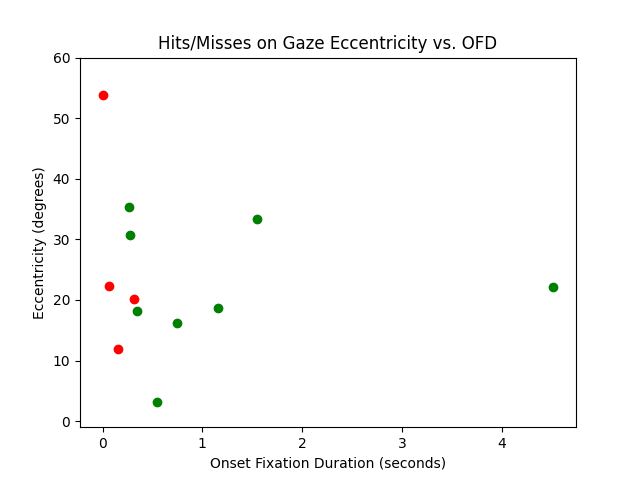

In [22]:
# target tuples, go back and find labels
saccade_onsets = 0
fixation_onsets = 0
noise_onsets = 0
fig, ax = plt.subplots()
graph_tuples = []

for target_tuple in hits_and_misses:
    # for either hit or miss, go back and find the ofd
    # check if you're in a fixation rn
    if target_tuple[0].GazeValid_COMBINED==0: # check gaze validity 
        continue
    target_locindf = target_tuple[0].name
    onset_gaze_event = recdf_with_labels.loc[target_locindf].label  
    OFD = 0
    pitch = recdf_with_labels.loc[target_locindf].gaze2target_pitch
           # + recdf_with_labels.loc[target_locindf].head2target_pitch
    yaw = recdf_with_labels.loc[target_locindf].gaze2target_yaw 
           # + recdf_with_labels.loc[target_locindf].head2target_yaw
    
    if onset_gaze_event == 0:
        fixation_onsets += 1
        # go back and look at when this current fixation ends
        # labels going back from current gaze
        labels_upto_curr = recdf_with_labels.loc[target_locindf::-1].label 
        np.diff(labels_upto_curr)
        labels_upto_curr = recdf_with_labels.loc[target_locindf::-1].label 
        label_diff = np.diff(labels_upto_curr)!=0
        first_fixation_idx = target_locindf - np.argmax(label_diff)
        OFD = recdf_with_labels.loc[target_locindf].TimeElapsed -\
                recdf_with_labels.loc[first_fixation_idx].TimeElapsed
        
        eccentricity = np.linalg.norm([recdf_with_labels.loc[target_locindf].gaze2target_pitch,
                                      recdf_with_labels.loc[target_locindf].gaze2target_yaw])*180/np.pi
        ax.scatter(OFD, eccentricity, c='r' if target_tuple[1] is False else 'g')
        graph_tuples += (OFD, eccentricity, target_tuple[1] is False, pitch, yaw)
    elif onset_gaze_event == 1:
        saccade_onsets += 1
        OFD = 0        
        eccentricity = np.linalg.norm([recdf_with_labels.loc[target_locindf].gaze2target_pitch,
                                      recdf_with_labels.loc[target_locindf].gaze2target_yaw])*180/np.pi
        ax.scatter(OFD, eccentricity, c='r' if target_tuple[1] is False else 'g')
        graph_tuples += (OFD, eccentricity, target_tuple[1] is False, pitch, yaw)
    else:
        noise_onsets += 1
    # print(target_locindf, OFD)
print("{}/{} valid targets".format(
        fixation_onsets+saccade_onsets+noise_onsets,
        len(hits_and_misses)))
print("{} fixation onsets, {} sacc, {} noise".format(fixation_onsets, saccade_onsets, noise_onsets))

#plt.xlim(0, )
ax.set_ylim(-1, 60)
ax.set_xlabel("Onset Fixation Duration (seconds)")
ax.set_ylabel("Eccentricity (degrees)")
ax.set_title("Hits/Misses on Gaze Eccentricity vs. OFD")

In [17]:
# temp hack for henny meeting: save graph tuples
graph_data_filname = Path("temp_data").joinpath(recording_name+"_OFDvEcc.pkl")
with open(graph_data_filname, 'wb') as f:
    pkl.dump(graph_tuples, f)

# Saccade amplitude analysis


12/12 valid targets
11 fixation onsets, 1 sacc, 0 noise


Text(0.5, 1.0, 'Hits/Misses on Gaze Eccentricity vs. OFD')

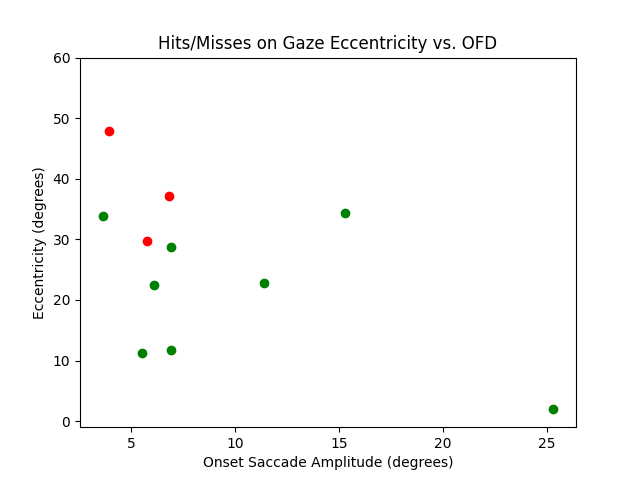

In [80]:
# target tuples, go back and find labels
saccade_onsets = 0
fixation_onsets = 0
noise_onsets = 0
fig, ax = plt.subplots()
graph_tuples = []

for target_tuple in hits_and_misses:
    # for either hit or miss, go back and find the ofd
    # check if you're in a fixation rn
    if target_tuple[0].GazeValid_COMBINED==0: # check gaze validity 
        continue
    target_locindf = target_tuple[0].name
    onset_gaze_event = recdf_with_labels.loc[target_locindf].label  
    OSA = 0
    pitch = recdf_with_labels.loc[target_locindf].gaze2target_pitch
           # + recdf_with_labels.loc[target_locindf].head2target_pitch
    yaw = recdf_with_labels.loc[target_locindf].gaze2target_yaw 
           # + recdf_with_labels.loc[target_locindf].head2target_yaw
    
    if onset_gaze_event == 0:
        fixation_onsets += 1
        # go back and look at when this current fixation ends
        # labels going back from current gaze
        labels_upto_curr = recdf_with_labels.loc[target_locindf::-1].label 
        label_diff = np.diff(labels_upto_curr)!=0
        first_fixation_idx = target_locindf - np.argmax(label_diff) # first fixation of this idx
        
        labels_upto_curr = recdf_with_labels.loc[target_locindf::-1].label 
        rev_fix_idcs = np.where(labels_upto_curr==0)
        last_nonfix_offset = np.where(np.diff(rev_fix_idcs)>1)[1][0]# where is the break in the fixation
        last_fixend_idx = rev_fix_idcs[0][last_nonfix_offset+1]
        # onset saccade idx
        OSA = np.linalg.norm(recdf_with_labels.loc[target_locindf].GazeDir_COMBINED - recdf_with_labels.loc[last_fixend_idx].GazeDir_COMBINED)*180/np.pi
        
                
        eccentricity = np.linalg.norm([recdf_with_labels.loc[target_locindf].gaze2target_pitch,
                                      recdf_with_labels.loc[target_locindf].gaze2target_yaw])*180/np.pi
        ax.scatter(OSA, eccentricity, c='r' if target_tuple[1] is False else 'g')
        graph_tuples += (OSA, eccentricity, target_tuple[1] is False, pitch, yaw)
        
    elif onset_gaze_event == 1:
        saccade_onsets += 1
        # OFD = 0        
        # eccentricity = np.linalg.norm([recdf_with_labels.loc[target_locindf].gaze2target_pitch,
        #                               recdf_with_labels.loc[target_locindf].gaze2target_yaw])*180/np.pi
        # ax.scatter(OFD, eccentricity, c='r' if target_tuple[1] is False else 'g')
        # graph_tuples += (OFD, eccentricity, target_tuple[1] is False, pitch, yaw)
    else:
        noise_onsets += 1
    # print(target_locindf, OFD)
print("{}/{} valid targets".format(
        fixation_onsets+saccade_onsets+noise_onsets,
        len(hits_and_misses)))
print("{} fixation onsets, {} sacc, {} noise".format(fixation_onsets, saccade_onsets, noise_onsets))

#plt.xlim(0, )
ax.set_ylim(-1, 60)
ax.set_xlabel("Onset Saccade Amplitude (degrees)")
ax.set_ylabel("Eccentricity (degrees)")
ax.set_title("Hits/Misses on Gaze Eccentricity vs. OFD")

# OFD analysis with Eye gaze + Head compensation

In [192]:
df2 = df1.copy()
df2['Lgaze_x'] = df1.GazeDir_LEFT.apply(lambda x: x[0])
df2['Lgaze_y'] = df1.GazeDir_LEFT.apply(lambda x: x[1])
df2['Lgaze_z'] = df1.GazeDir_LEFT.apply(lambda x: x[2])

df2['Rgaze_x'] = df1.GazeDir_RIGHT.apply(lambda x: x[0])
df2['Rgaze_y'] = df1.GazeDir_RIGHT.apply(lambda x: x[1])
df2['Rgaze_z'] = df1.GazeDir_RIGHT.apply(lambda x: x[2])

df2['Cgaze_x'] = df1.GazeDir_COMBINED.apply(lambda x: x[0])
df2['Cgaze_y'] = df1.GazeDir_COMBINED.apply(lambda x: x[1])
df2['Cgaze_z'] = df1.GazeDir_COMBINED.apply(lambda x: x[2])


LgazeRaySplitDF = pd.DataFrame(df2[['Lgaze_x', 'Lgaze_y', 'Lgaze_z']])
LgazeRaySplitDF.rename(columns={'Lgaze_x': 'x', 'Lgaze_y': 'y', 'Lgaze_z': 'z'}, inplace=True)
LgazeRaySplitDF['timestamp'] = df2["TimeElapsed"]
LgazeRaySplitDF['confidence'] = df2["EyeOpennessValid_LEFT"].astype(bool) # remove all gazes where an eye was closed

RgazeRaySplitDF = pd.DataFrame(df2[['Rgaze_x', 'Rgaze_y', 'Rgaze_z']])
RgazeRaySplitDF.rename(columns={'Rgaze_x': 'x', 'Rgaze_y': 'y', 'Rgaze_z': 'z'}, inplace=True)
RgazeRaySplitDF['timestamp'] = df2["TimeElapsed"]
RgazeRaySplitDF['confidence'] = df2["EyeOpennessValid_RIGHT"].astype(bool) # remove all gazes where an eye was closed

In [193]:
velL = EyeClassifier.preprocess(LgazeRaySplitDF, dist_method='vector')
velL.velocity = velL.velocity.astype(float)
velR = EyeClassifier.preprocess(RgazeRaySplitDF, dist_method='vector')
velR.velocity = velR.velocity.astype(float)

In [148]:
# add approx head compensation
# gaze+head values
gaze_pitches, gaze_yaws = GetGazeDeviationFromHead(df2.Cgaze_x, df2.Cgaze_y, df2.Cgaze_z)

head_rots = df2.CameraRot.values
head_pitches =   df2.CameraRot.apply(lambda x: x[0])
head_yaws = df2.CameraRot.apply(lambda x: x[2])
    
gaze_head_pitches = gaze_pitches + head_pitches
gaze_head_yaws = gaze_yaws + head_yaws       

In [200]:
# Create the new pd

gazeHeadDF = pd.DataFrame(df2[['TimeElapsed']])
gazeHeadDF = gazeHeadDF.rename(columns={'TimeElapsed':'timestamp'})
gazeHeadDF['confidence'] = (df2.EyeOpennessValid_LEFT*df2.EyeOpennessValid_RIGHT).astype(bool)
gazeHeadDF['x'] = gaze_head_pitches
gazeHeadDF['y'] = gaze_head_yaws
gazeHeadDF['z'] = np.zeros(len(gaze_head_pitches))

In [212]:
vel_w = EyeClassifier.preprocess(gazeHeadDF, dist_method='euclidean')
model = EyeClassifier()
model.fit(world=vel_w)

# raw_vel = vel_w[np.logical_not(vel_w.velocity.isna())].velocity.values
# raw_vel[raw_vel > raw_vel.mean() + 3 * raw_vel.std()]
# print("Velocity Means: ",model.world_model.means_)

Velocity Means:  [[  6.05573297]
 [106.9746424 ]]


In [213]:
labelsw, indiv_labelsw = model.predict(world=vel_w)
# print(labels)
# 0- fix, 1- sac, -1 -> noise
labels_uniquew = labelsw[1::2]
labels_uniquew.index = np.arange(1, len(labels_uniquew) + 1) # start index from 1 instead of 0
labels_npw = labels_uniquew.to_numpy()
print("labels_npw.shape: ", labels_npw.shape)
# add the labels to the original df:
recdf_with_labelsw = df2.join(labels_uniquew["label"])

labels_npw.shape:  (2563, 5)


In [214]:
print("Num fixation total pts: ", np.sum(labels_npw[:,2]))
print("Num saccades total pts: ", np.sum(labels_npw[:,3]))
print("Num noise total pts: ", np.sum(labels_npw[:,4]))
print()
# filter the consecutives
print("Num fixations: ", np.sum(np.diff(labels_npw[:, 2]) == 1))
print("Num saccades: ", np.sum(np.diff(labels_npw[:, 3]) == 1))
print("Num noise: ", np.sum(np.diff(labels_npw[:, 4]) == 1))
print("Num LightOns: ", num_targets_spawned)

Num fixation total pts:  2041
Num saccades total pts:  503
Num noise total pts:  19

Num fixations:  268
Num saccades:  270
Num noise:  10
Num LightOns:  12
